In [1]:
import pandas as pd;
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [2]:
data = pd.read_csv("HR_data/HR_comma_sep.csv");
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


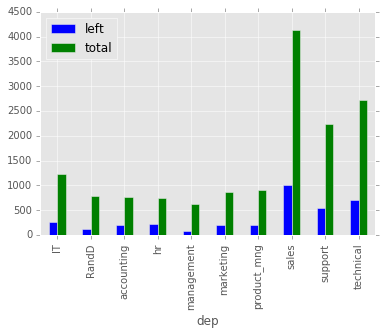

In [3]:
data1 = data[['left', 'sales']]
data1 = data1.groupby('sales').agg(['sum', 'count']).reset_index()
data1.columns = data1.columns.get_level_values(0)
data1.columns = ['dep', 'left', 'total']
data1.plot(x='dep',y=['left', 'total'],kind='bar')
plt.show()

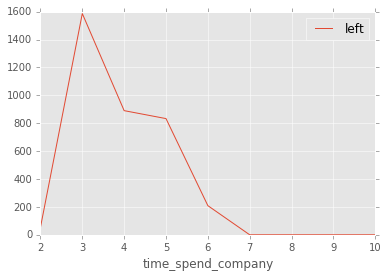

In [4]:
#Time spend at the company vs left! After 3 years at the company chances of leaving it decreases
data1 = data[['left', 'time_spend_company']]
data1 = data1.groupby('time_spend_company').agg(['sum', 'count']).reset_index()
data1.columns = data1.columns.get_level_values(0)
data1.columns = ['time_spend_company', 'left', 'total']
data1.plot(x='time_spend_company',y=['left'])
plt.show()

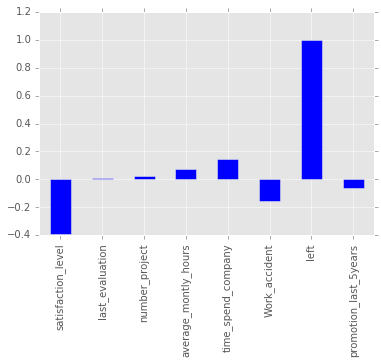

In [5]:
#compute correlation of left colum with other variables
corr = data.corr()
corr['left'].plot(kind='bar')
plt.show()

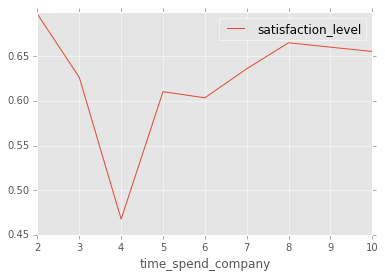

In [6]:
#Satisfication level vs time spent in the company!
data1 = data[['time_spend_company', 'satisfaction_level']]
data1 = data1.groupby('time_spend_company').agg(['mean']).reset_index()
data1.columns = data1.columns.get_level_values(0)
data1.plot(x='time_spend_company', y='satisfaction_level')
plt.show()

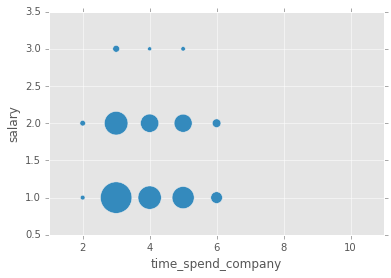

In [7]:
#Relation between number of employees leave the company in a relation with both their salaries
#and number of years in the company
data1 = data[['time_spend_company', 'salary','left']]
data1 = data1.groupby(['time_spend_company','salary']).agg(['sum']).reset_index()
data1.columns = data1.columns.get_level_values(0)
#convert salary column to numeric values high=>3, medium=>2, low=>1
data1.loc[:,'salary'] = data1.apply(lambda row : {'high':3, 'medium':2, 'low':1}[row['salary']], 1)
data1.plot(x='time_spend_company', y='salary', s=data1['left'], kind='scatter')
plt.show()

In [8]:
#Building first simple classifier based on Naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

#convert salary into numerica levels
data.loc[:,'salary'] = data.apply(lambda row : {'high':3, 'medium':2, 'low':1}[row['salary']], 1)
#drop department column
data = data.drop('sales', 1)
gnb = GaussianNB()

train = data.sample(frac=0.8, random_state=1)
test  = data.loc[~data.index.isin(train.index)]

#prediction based on: last_evaluation, number_project, average_montly_hours, 
#time_spend_company, salary
train_x = train[[1, 2, 3, 4, 8]]
test_x = test[[1, 2, 3, 4, 8]]

model = gnb.fit(train_x, train.left)
y_predict = model.predict(test_x)


print confusion_matrix(test.left, y_predict)
print accuracy_score(test.left, y_predict)

[[2215   83]
 [ 490  212]]
0.809


In [23]:
#Trying decision trees model
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt = dt.fit(train_x, train.left)
y_predict = dt.predict(test_x)

print confusion_matrix(test.left, y_predict)
print accuracy_score(test.left, y_predict)
print dt.get_params()

[[2245   53]
 [  31  671]]
0.972
{'presort': False, 'splitter': 'best', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'min_impurity_split': 1e-07, 'max_features': None, 'max_depth': None, 'class_weight': None}


In [21]:
#To avoid overfitting we will search over the paramters of our DT model to find the best
#params
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

max_depth      = range(1, 10)
max_leaf_nodes = range(2, 10) 

parameters = {'max_depth': max_depth, 'max_leaf_nodes': max_leaf_nodes}

clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=5)
clf.fit(train_x, train.left)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [22]:
print clf.best_params_

dt = tree.DecisionTreeClassifier(max_depth=4, max_leaf_nodes=9)
dt = clf.fit(train_x, train.left)
y_predict = dt.predict(test_x)

print(classification_report(test.left, y_predict))

{'max_leaf_nodes': 9, 'max_depth': 8}
             precision    recall  f1-score   support

          0       0.97      0.96      0.97      2298
          1       0.88      0.91      0.89       702

avg / total       0.95      0.95      0.95      3000

0.949666666667


In [19]:
clf.scorer_

<function sklearn.metrics.scorer._passthrough_scorer>